In [120]:
import pandas as pd
import numpy as np
import csv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC

from IPython.display import Image
from sklearn import tree
import pydotplus
import os
from os import system
from sklearn.linear_model import LogisticRegression
from datetime import datetime
import pickle

In [242]:
pd.set_option('max_seq_items', 200)

In [257]:
shows = pd.read_csv('good_shows_data2.csv')

In [258]:
shows.columns

Index([u'json', u'title_rough', u'check', u'title', u'imdb_id', u'big_json',
       u'seasons', u'cancelled', u'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords',
       u'first_year', u'is_new', u'fixed_runtime', u'is_action',
       u'is_adventure', u'is_animation', u'is_biography', u'is_comedy',
       u'is_crime', u'is_documentary', u'is_drama', u'is_family',
       u'is_fantasy', u'is_game', u'is_history', u'is_horror', u'is_music',
       u'is_musical', u'is_mystery', u'is_news', u'is_reality', u'is_romance',
       u'is_sci', u'is_short', u'is_sport', u'is_talk', u'is_thriller',
       u'is_war', u'is_western', u'release_month', u'release_weekday',
       u'release_monthday', u'stemmed_plot', u'stemmed_keywords',
       u'keyword_adult', u'keyword_african', u'keyword_alien',
       u'keyword_american', u'keyword_angel', u'keyword_anim', u'keyword_base',
       u'keyword_best', u'keyword_black', u'keyword_book', u'keywor

In [259]:
## dropping old shows
shows = shows[shows['release_date']>=1980]

In [260]:
## dropping shows where I don't know whether they were cancelled
shows = shows[shows['seasons'] != 0]

In [261]:
shows['release_date'] = shows['release_date'].dropna().apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
shows['release_month'] = shows['release_date'].dropna().apply(lambda x: x.strftime('%m'))
shows['release_month'] = shows['release_month'].dropna().apply(lambda x: int(x))
shows['release_weekday'] = shows['release_date'].dropna().apply(lambda x: x.strftime('%w'))
shows['release_weekday'] = shows['release_weekday'].dropna().apply(lambda x: int(x))

shows['started_sunday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==0 else 0)
shows['started_monday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==1 else 0)
shows['started_tuesday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==2 else 0)
shows['started_wednesday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==3 else 0)
shows['started_thursday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==4 else 0)
shows['started_friday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==5 else 0)
shows['started_saturday'] = shows['release_weekday'].dropna().apply(lambda x: 1 if int(x)==6 else 0)

In [262]:
shows['started_on_first'] = shows['release_monthday'].dropna().apply(lambda x: 1 if x==1 else 0)

In [263]:
shows.columns

Index([u'json', u'title_rough', u'check', u'title', u'imdb_id', u'big_json',
       u'seasons', u'cancelled', u'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords',
       u'first_year', u'is_new', u'fixed_runtime', u'is_action',
       u'is_adventure', u'is_animation', u'is_biography', u'is_comedy',
       u'is_crime', u'is_documentary', u'is_drama', u'is_family',
       u'is_fantasy', u'is_game', u'is_history', u'is_horror', u'is_music',
       u'is_musical', u'is_mystery', u'is_news', u'is_reality', u'is_romance',
       u'is_sci', u'is_short', u'is_sport', u'is_talk', u'is_thriller',
       u'is_war', u'is_western', u'release_month', u'release_weekday',
       u'release_monthday', u'stemmed_plot', u'stemmed_keywords',
       u'keyword_adult', u'keyword_african', u'keyword_alien',
       u'keyword_american', u'keyword_angel', u'keyword_anim', u'keyword_base',
       u'keyword_best', u'keyword_black', u'keyword_book', u'keywor

In [264]:
shows = shows.drop(['json', u'title_rough', u'check', u'big_json',
       u'seasons', 'runtime', u'genres', u'imdb_rating',
       u'release_date', u'plot', u'year', u'type', u'votes', u'keywords', u'is_new', 
        'stemmed_plot', u'stemmed_keywords', 'plot_cleaned', u'network', 'release_month', 
                    'release_weekday', 'fixed_runtime', 'keyword_new'], axis=1)


In [265]:
shows.columns

Index([u'title', u'imdb_id', u'cancelled', u'first_year', u'is_action',
       u'is_adventure', u'is_animation', u'is_biography', u'is_comedy',
       u'is_crime', u'is_documentary', u'is_drama', u'is_family',
       u'is_fantasy', u'is_game', u'is_history', u'is_horror', u'is_music',
       u'is_musical', u'is_mystery', u'is_news', u'is_reality', u'is_romance',
       u'is_sci', u'is_short', u'is_sport', u'is_talk', u'is_thriller',
       u'is_war', u'is_western', u'release_monthday', u'keyword_adult',
       u'keyword_african', u'keyword_alien', u'keyword_american',
       u'keyword_angel', u'keyword_anim', u'keyword_base', u'keyword_best',
       u'keyword_black', u'keyword_book', u'keyword_boy', u'keyword_boyfriend',
       u'keyword_brother', u'keyword_california', u'keyword_celebr',
       u'keyword_charact', u'keyword_child', u'keyword_citi',
       u'keyword_comedi', u'keyword_comedian', u'keyword_comic',
       u'keyword_cult', u'keyword_daughter', u'keyword_death',
       u'k

In [266]:
## export clean modeling data

# shows.to_csv('clean_modeling_data.csv')


In [269]:
shows = shows.drop(['title', 'imdb_id'], axis=1)

In [132]:
shows.shape

(2061, 144)

In [133]:
# shows.columns

In [134]:
shows.shape

(2061, 144)

In [135]:
shows.dropna().shape

(2061, 144)

In [136]:
## defining dependent/independent variables
y = shows['cancelled']
x = shows.drop('cancelled', axis=1)

In [137]:
# x.columns

In [138]:
## Base probability
y.mean()

0.39349830179524503

In [139]:
## train/test split
x_train, x_test, y_train, y_test = train_test_split(x,y)

In [140]:
# x_train.shape

In [141]:
# x_test.shape

In [142]:
# y_train.shape

In [143]:
# y_test.shape

In [144]:
## runs model
def run_model(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    print "Training set score: ", model.score(x_train, y_train)
    print "Test set score: ", model.score(x_test, y_test)
    predictions = model.predict(x_test)
    print "\nConfusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n",classification_report(y_test, predictions)

In [145]:
## plots ROC curve
def plot_roc(x_test, y_test, model):
    fpr, tpr, _ = roc_curve(y_test, model.predict_proba(x_test)[:,1])
    roc_auc = auc(fpr, tpr)
    print 'ROC AUC: %0.2f' % roc_auc
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

## Random Forest

In [146]:
rf = RandomForestClassifier(min_samples_leaf=5)

In [147]:
run_model(x_train, y_train, x_test, y_test, rf)

Training set score:  0.780582524272
Test set score:  0.686046511628

Confusion Matrix:
      predicted_0  predicted_1
is_0          263           53
is_1          109           91

Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.83      0.76       316
          1       0.63      0.46      0.53       200

avg / total       0.68      0.69      0.67       516



In [148]:
rf.predict_proba(x_test)

array([[ 0.6037591 ,  0.3962409 ],
       [ 0.60745273,  0.39254727],
       [ 0.48892697,  0.51107303],
       ..., 
       [ 0.48127501,  0.51872499],
       [ 0.44443611,  0.55556389],
       [ 0.55474529,  0.44525471]])

ROC AUC: 0.71


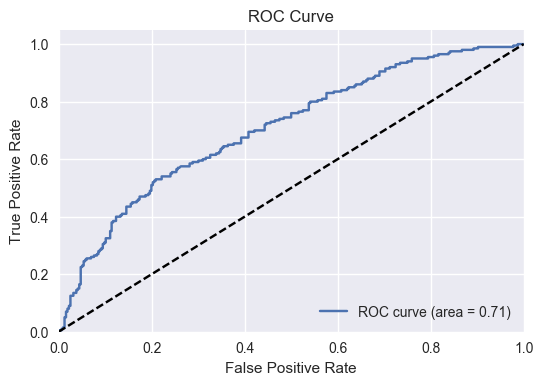

In [149]:
plot_roc(x_test, y_test, rf)

In [215]:
x_train.shape

(1545, 143)

## Random Forest with grid search

In [150]:
# parameters = {
#     "n_estimators" : [10, 25, 50, 100],
#     "max_depth" : [5,7,10,15],
#     "max_features" : [0.25, 0.5, 0.75],
#     "min_samples_leaf" : [2,3,4,5]
# }

In [151]:
# gs_rf = RandomForestClassifier()
# grid_search = GridSearchCV(gs_rf,param_grid=parameters, cv=7, n_jobs=-1)

In [152]:
## 12:21 - 12:22
# grid_search.fit(x_train, y_train)

In [153]:
# grid_search.best_estimator_

In [154]:
# run_model(x_train, y_train, x_test, y_test, grid_search.best_estimator_)

In [155]:
# plot_roc(x_test, y_test, grid_search.best_estimator_)

In [156]:
# grid_search.best_estimator_.predict_proba(x_test)

In [157]:
# rf_feature_importances = pd.DataFrame(grid_search.best_estimator_.feature_importances_,
#                                    index = x_train.columns,
#                                     columns=['importance']).sort_values('importance',
#                                     ascending=False)
# rf_feature_importances.head(20)

## Decision Tree

In [158]:
# DecisionTreeClassifier()

In [159]:
## tune hyperparameters here
# dt = DecisionTreeClassifier(
#     max_depth=15, 
#     min_samples_leaf=4,
#     max_leaf_nodes=8,
#     criterion='gini'
# )

In [160]:
# run_model(x_train, y_train, x_test, y_test, dt)

In [161]:
# plot_roc(x_test, y_test, dt)

In [162]:
def tune_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    print "Confusion Matrix:\n", pd.DataFrame(confusion_matrix(y_test, new_predictions), 
                                              columns=['predicted_0', 'predicted_1'], index=['is_0', 'is_1'])
    print "\nClassification Report:\n", classification_report(y_test, new_predictions)
    plt.hist(new_predictions)
    plt.xlabel('New Predictions')
    plt.ylabel('Frequency')
    plt.title('Distribution of New Predictions')
    plt.show()

In [163]:
# tune_predictions(dt, x_test, y_test, .30)

In [164]:
# tune_predictions(dt, x_test, y_test, .60)

In [165]:
## plots the distribution of prediction probabilities for the 1 class
# def plot_proba(x_test, model):
#     predict = model.predict_proba(x_test)
#     plt.hist(predict[:,1], bins=40)
#     plt.ylabel('Frequency')
#     plt.xlabel('Class 1 Probability Cutoff')
#     plt.show()

In [166]:
# plot_proba(x_test, dt)

In [167]:
# plt.hist(predict[:,1])

In [168]:
# plt.hist(predict)

In [169]:
# plt.hist(predictions_60)

In [170]:
# confusion_matrix(y_test, predictions_60)

In [171]:
# tune_predictions(dt, x_test, y_test, .30)

In [172]:
# tune_predictions(dt, x_test, y_test, .40)

## grid-searching the decision tree

In [173]:
# dt_for_gs = DecisionTreeClassifier()

In [174]:
# params_dt = {
#     "max_depth":[10,15,20],
#     "min_samples_leaf":[2,3,4,5],
#     "max_leaf_nodes":[4,6,8,10],
#     "criterion":['gini', 'entropy']
# }

In [175]:
# gs_dt = GridSearchCV(dt_for_gs, params_dt)

In [176]:
# gs_dt.fit(x_train, y_train)

In [177]:
# gs_dt.best_estimator_

In [178]:
# run_model(x_train, y_train, x_test, y_test, gs_dt.best_estimator_)

In [179]:
## in the original model, the false negatives were higher than the true positives. This is terrible, and needs fixing.


# plot_proba(x_test, gs_dt.best_estimator_)

In [180]:
## with probability=0.4, model score is 0.62. the false negatives are down, but the false positives are up.
# tune_predictions(gs_dt, x_test, y_test, .40)

In [181]:
# confusion_matrix(y_test, predictions_60)

In [182]:
def get_predictions(model, x_test, y_test, probability):
    predict = model.predict_proba(x_test)
    new_predictions = []
    for i in predict:
        if i[1] >= probability:
            new_predictions.append(1)
        else:
            new_predictions.append(0)
    return new_predictions

In [183]:
def find_optimal_probability(model, x_test, y_test):
    probabilities = range(1,101)
    new_probabilities = []
    for i in probabilities:
        new_probabilities.append(float(i)/100)
    range_of_scores = []
    for i in new_probabilities:
        new_preds = get_predictions(model, x_test, y_test, i)
        cmatrix = confusion_matrix(y_test, new_preds)
        new_model_score = (cmatrix[0,0] + cmatrix[1,1])/float(np.sum(cmatrix))
        range_of_scores.append(new_model_score)
    
    plt.plot(new_probabilities, range_of_scores)
    plt.title("Model Scores at Different Cutoff Probabilities")
    plt.xlabel("Probability Cutoff")
    plt.ylabel("Model Score")
    plt.show()

In [184]:
# find_optimal_probability(dt, x_test, y_test)

## Gradient Boosting

In [185]:
# GradientBoostingClassifier()

In [186]:
# boost_default = GradientBoostingClassifier()

In [187]:
# boost = GradientBoostingClassifier(
#     n_estimators=500, 
#     max_depth= 6,
#     learning_rate= 0.1, 
#     min_samples_leaf=2
#     )

In [188]:
# run_model(x_train, y_train, x_test, y_test, boost)

In [189]:
# run_model(x_train, y_train, x_test, y_test, boost_default)

In [190]:
# boost_feature_importances = pd.DataFrame(boost_default.feature_importances_,
#                                    index = x_train.columns,
#                                     columns=['importance']).sort_values('importance',
#                                     ascending=False)
# boost_feature_importances.head(20)

# XGBoost

In [191]:
# xgb = XGBClassifier()

In [192]:
# run_model(x_train, y_train, x_test, y_test, xgb)

## ADA Boosting

In [193]:
rfc = RandomForestClassifier(min_samples_leaf=4)

In [194]:
ada_default = AdaBoostClassifier()

In [195]:
ada = AdaBoostClassifier(base_estimator=rfc, n_estimators=100)

In [196]:
ada_boost = AdaBoostClassifier(n_estimators=100)

In [197]:
ada_default

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [198]:
run_model(x_train, y_train, x_test, y_test, ada_default)

Training set score:  0.708737864078
Test set score:  0.682170542636

Confusion Matrix:
      predicted_0  predicted_1
is_0          234           82
is_1           82          118

Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.74      0.74       316
          1       0.59      0.59      0.59       200

avg / total       0.68      0.68      0.68       516



In [199]:
run_model(x_train, y_train, x_test, y_test, ada)

Training set score:  1.0
Test set score:  0.695736434109

Confusion Matrix:
      predicted_0  predicted_1
is_0          251           65
is_1           92          108

Classification Report:
             precision    recall  f1-score   support

          0       0.73      0.79      0.76       316
          1       0.62      0.54      0.58       200

avg / total       0.69      0.70      0.69       516



In [200]:
run_model(x_train, y_train, x_test, y_test, ada_boost)

Training set score:  0.725566343042
Test set score:  0.68992248062

Confusion Matrix:
      predicted_0  predicted_1
is_0          239           77
is_1           83          117

Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.76      0.75       316
          1       0.60      0.58      0.59       200

avg / total       0.69      0.69      0.69       516



In [201]:
ada_boost.fit(x_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=100, random_state=None)

In [202]:
ada_boost.score(x_train, y_train)

0.72556634304207124

In [203]:
ada_boost.score(x_test, y_test)

0.68992248062015504

In [204]:
ada_boost.predict(x_test)

array([0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0,
       0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1,
       1, 0,

## pickling adaboost

In [205]:
ada_boost_pickle_path = 'model_implementation/ada_boost_pickle.pkl'
ada_boost_pickle = open(ada_boost_pickle_path, 'wb')
pickle.dump(ada_boost, ada_boost_pickle)
ada_boost_pickle.close()

ROC AUC: 0.74


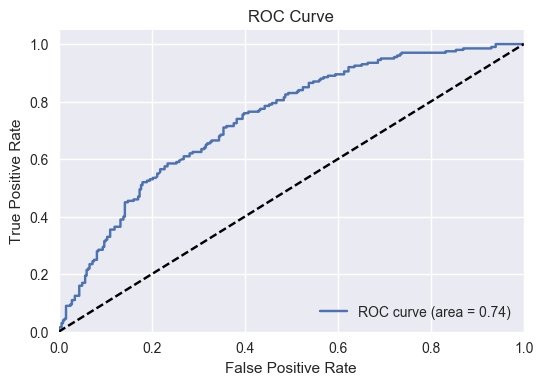

In [206]:
plot_roc(x_test, y_test, ada_boost)

In [207]:
# find_optimal_probability(ada_boost, x_test, y_test)

In [208]:
adaboost_feature_importances = pd.DataFrame(ada_boost.feature_importances_,
                                   index = x_train.columns,
                                    columns=['importance']).sort_values('importance',
                                    ascending=False)
adaboost_feature_importances.head(20)

,importance
first_year,0.13
release_monthday,0.05
half_hour,0.03
is_reality,0.03
keyword_spoof,0.02
from_Nickelodeon,0.02
from_Fox,0.02
keyword_relationship,0.02
from_ABC,0.02
full_hour,0.02


In [210]:
x_test.shape

(516, 143)

In [227]:
x_test.columns.sort_values()[91]

'keyword_offic'

In [228]:
x_test.columns.sort_values()

Index([u'first_year', u'from_ABC', u'from_CBS', u'from_Cartoon',
       u'from_Comedy', u'from_Disney', u'from_Fox', u'from_HBO', u'from_MTV',
       u'from_NBC', u'from_Nickelodeon', u'from_WB', u'full_hour',
       u'half_hour', u'is_action', u'is_adventure', u'is_animation',
       u'is_biography', u'is_comedy', u'is_crime', u'is_documentary',
       u'is_drama', u'is_family', u'is_fantasy', u'is_game', u'is_history',
       u'is_horror', u'is_music', u'is_musical', u'is_mystery', u'is_news',
       u'is_reality', u'is_romance', u'is_sci', u'is_short', u'is_sport',
       u'is_talk', u'is_thriller', u'is_war', u'is_western', u'keyword_adult',
       u'keyword_african', u'keyword_alien', u'keyword_american',
       u'keyword_angel', u'keyword_anim', u'keyword_base', u'keyword_best',
       u'keyword_black', u'keyword_book', u'keyword_boy', u'keyword_boyfriend',
       u'keyword_brother', u'keyword_california', u'keyword_celebr',
       u'keyword_charact', u'keyword_child', u'keyword_

## Decision tree for show

In [209]:
## this will create a single decision tree from the whole dataset that is readable by humans. 
## for display purposes only. it will be tuned to have approximately the same score as the AdaBoost model

# dt_for_show = DecisionTreeClassifier(
#                     max_depth=7,
#                     min_samples_leaf=5,
#                     max_leaf_nodes=10
#     class_weight=None, criterion='gini', max_depth=10,
#             max_features=None, max_leaf_nodes=10, min_samples_leaf=2,
#             min_samples_split=2, min_weight_fraction_leaf=0.0,
#             presort=False, random_state=None, splitter='best'
)

SyntaxError: invalid syntax (<ipython-input-209-bdb49d72b0bf>, line 12)

In [ ]:
# dt_for_show.fit(x,y)

In [ ]:
# dt_for_show.score(x,y)

In [ ]:
## exporting decision tree to png

# dtree = dt_for_show.fit(x, y)

# dotfile = open("dtree2.dot", 'w')
# tree.export_graphviz(dtree, 
#                      out_file = dotfile, 
#                      feature_names = x.columns, 
#                      class_names=['renewed', 'cancelled'],  
#                      filled=True, 
#                      rounded=True,
#                      special_characters=True,
#                      impurity=False,
#                      label='none'
#                     )
# dotfile.close()

# system('dot -Tpng dtree2.dot -o dtree2.png')

In [ ]:
# dt_show_feature_importances = pd.DataFrame(dt_for_show.feature_importances_,
#                                    index = x_train.columns,
#                                     columns=['importance']).sort_values('importance',
#                                     ascending=False)
# dt_show_feature_importances.head(20)

## Logistic regression

In [ ]:
# lr = LogisticRegression()

In [ ]:
# run_model(x_train, y_train, x_test, y_test, lr)

In [ ]:
# x['started_saturday'].sum()

# Support Vector Machines

In [ ]:
# svc = SVC(verbose=True)
# nusvc = NuSVC()
# linsvc = LinearSVC()

In [ ]:
# run_model(x_train, y_train, x_test, y_test, svc)

In [ ]:
# run_model(x_train, y_train, x_test, y_test, nusvc)

In [ ]:
# run_model(x_train, y_train, x_test, y_test, linsvc)